In [1]:
#The data contains a text file which has pairs of spanish sentence followed by its translated english sentence 

Using TensorFlow backend.


In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#Function to read the file
def read_text(filename):
        # open the file
        file = open(filename, mode='r')
        
        # read all text
        text = file.read().decode('UTF-8').encode('ascii',errors='ignore')
        file.close()
        return text

In [3]:
# Function to split a text into sentences 
def to_lines(text):
      sents = text.split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
#Reading the data from the file
data = read_text('spa.txt')

In [5]:
#print(data)
#print(type(data))

In [6]:
spa_eng = to_lines(data)

In [7]:
#Printing the first five 5 examples
print(type(spa_eng))
print(len(spa_eng))
spa_eng[:5]

<type 'list'>
120615


[['Go.', 'Ve.'],
 ['Go.', 'Vete.'],
 ['Go.', 'Vaya.'],
 ['Go.', 'Vyase.'],
 ['Hi.', 'Hola.']]

In [8]:
#Making two lists of English and Spanish sentences
import numpy as np
x1=[]
x2=[]
for i in spa_eng[:-1]:
    x1.append(np.array(i[0]))
    x2.append(np.array(i[1]))


In [9]:
print(len(x1))
print(len(x2))

120614
120614


In [10]:
#Converting the lists to arrays
x1 = np.array(x1)
x1 = x1[:,np.newaxis]
x1.shape
x2 = np.array(x2)
x2 = x2[:,np.newaxis]
print(x2.shape)
print(x1.shape)


(120614, 1)
(120614, 1)


In [11]:
#Combining these two arrays using hstack
x1[0]
x2[0]
spa_eng1 = np.hstack((x1,x2))
print(spa_eng1.shape)
print(type(spa_eng1))
print(type(spa_eng1[0]))

(120614, 2)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [12]:
spa_eng1

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
        'Como suele haber varias pginas web sobre cualquier tema, normalmente slo le doy al botn de retroceso cuando entro en una pgina web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente pgina encontrada por Google y espero encontrar algo menos irritante.'],
       ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.',
        'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra

In [35]:
#Only the first 50000 sentence pairs to reduce the training time of the model
spa_eng = spa_eng1[:90000,:]

In [36]:
# Remove punctuation
spa_eng[:,0] = [s.translate(None, string.punctuation) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(None, string.punctuation) for s in spa_eng[:,1]]
print(type(spa_eng))
print(type(spa_eng[0,:]))

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [37]:
# convert text to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()

spa_eng[:8,:]

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ['go', 'vyase'],
       ['hi', 'hola'],
       ['run', 'corre'],
       ['run', 'corred'],
       ['who', 'quin']], dtype='|S329')

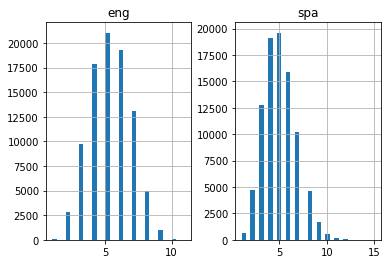

In [38]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
      eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
      spa_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})

length_df.hist(bins = 30)
plt.show()

In [39]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [40]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 7
print('English Vocabulary Size: %d' % eng_vocab_size)

print(type(eng_tokenizer.word_index))
#print(eng_tokenizer.word_index)

English Vocabulary Size: 10369
<type 'dict'>


In [41]:
# prepare spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Deutch Vocabulary Size: %d' % spa_vocab_size)

Deutch Vocabulary Size: 19104


In [42]:
# encode and pad sequences according to the maximum length of the sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [43]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

In [44]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

print(type(trainX))
print(trainX.shape)
print(trainY.shape)

<type 'numpy.ndarray'>
(72000, 8)
(72000, 7)


In [45]:
#keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(input_dim=in_vocab,output_dim=units, input_length = in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [46]:
# model compilation
model = define_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8, 512)            9781248   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 7, 512)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 7, 10369)          5319297   
Total params: 19,298,945
Trainable params: 19,298,945
Non-trainable params: 0
_________________________________________________________________


In [48]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [49]:
#total epochs =15 
filename = 'model.h1.24_feb_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=32, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 57600 samples, validate on 14400 samples
Epoch 1/32
57600/57600 [==============================] - 37s 636us/step - loss: 5.0337 - val_loss: 4.6408

Epoch 00001: val_loss improved from inf to 4.64082, saving model to model.h1.24_feb_19
Epoch 2/32
57600/57600 [==============================] - 34s 590us/step - loss: 4.5181 - val_loss: 4.4129

Epoch 00002: val_loss improved from 4.64082 to 4.41291, saving model to model.h1.24_feb_19
Epoch 3/32
57600/57600 [==============================] - 34s 598us/step - loss: 4.2665 - val_loss: 4.2290

Epoch 00003: val_loss improved from 4.41291 to 4.22900, saving model to model.h1.24_feb_19
Epoch 4/32
57600/57600 [==============================] - 35s 609us/step - loss: 3.9941 - val_loss: 3.9310

Epoch 00004: val_loss improved from 4.22900 to 3.93096, saving model to model.h1.24_feb_19
Epoch 5/32
57600/57600 [==============================] - 35s 600us/step - loss: 3.7163 - val_loss: 3.7078

Epoch 00005: val_loss improved from 3.93096 to 3.7

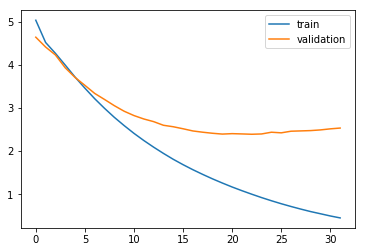

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [31]:
#model = load_model('model.h1.24_feb_19')

In [52]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [54]:
def get_word(n, tokenizer):
    t = None
    for word, index in tokenizer.word_index.items():
        if index == n:
            t = word
            
    return t

In [55]:
preds_text = []
for i in preds[:15,:]:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            a = (t == get_word(i[j-1],eng_tokenizer))
            b = (t == None)
            if a or b:
                     temp.append('')
            else:
                     temp.append(t)
        else:
            temp.append(t)
    preds_text.append(' '.join(temp))

In [56]:
pred_df = pd.DataFrame({'actual' : test[:,0][:15], 'predicted' : preds_text})

In [64]:
# print 5 rows randomly
pred_df.head(5)


,actual,predicted
0,we stayed at a hotel by the lake,staying at hotel by a hotel
1,tom lost his wallet,tom lost his
2,he left the window open,he left the window
3,she can speak english of course,she knows english of
4,where did you go last sunday,where did you go to last
